# B404B Modern Issues in Finance: Computational Finance in Python
*Submission Date: June 29, 2025*

This notebook contains the code and explanations of **group 2** for the assessment in the course **B404B Modern Issues in Finance: Computational Finance in Python**.

**Members in Group 2**

* Aaron
* Liqian Huang
* Nino Maisuradze
* Xuan Yang


**Table of Contents**


1. [Data Acquisition](#setup)
2. [Definition of Signals](#I)
3. [Computation of Signals and Resulting Positions](#II)
4. [Statistics of the Strategy](#III)
5. [Graphs of Strategy](#IV)


## Data Acquisition


In [306]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import module
from module import *

In [307]:
# define tickers of stocks that are to be analyzed
tickers = [ \
    'AAPL', #Apple
    'AMD',  #AMD
    'TSLA', #TSLA
    '^GSPC'] # S&P500 - Benchmark

# define time span of stock price data
start_date = '2020-01-01'
end_date = '2024-12-31'

# download the data
df_prices, df_price_changes = module.download_stock_price_data(tickers, start_date, end_date)

[*********************100%***********************]  4 of 4 completed


## Definition of Signals <a id="I"></a>


In [309]:
# DEFINE THREE TRADING SIGNALS

# DO YOUR RESEARCH IN A SEPARATE NOTEBOOK AND IMPLEMENT THE FINAL SIGNALS IN THE MODULE
# PLEASE PROVIDE THE FOLLOWING AS PART OF THE ASSESSMENT:
# - provide a reference to the related literature for each trading signal as mentioned below
# - provide your SEPARATE RESERACH NOTEBOOK in which you back your trading signals
#   and their parameters by empirical research:
#   - perform a systematic parameter search / optimization that backs your parameter selection empirically
#   - perform extensive in-sample and out-of-sample testing of your trading signals and parameters with respect to
#   -- companies / stocks
#   -- time horizons
#   - there is no example for your research notebook, you're completely free to develop it according to your research
# - provide a module.py file to re-use your code in both your assessment notebook and your research notebook

# REMEMBER THAT YOU MAY NOT USE BUILT-IN FUNCTIONS FROM OTHER LIBRARIES THAN NUMPY
# WHEN IN DOUBT - CODE A FUNCTION IN NUMPY ON YOUR OWN!
# EXAMPLE: .rolling().mean() is a built-in function in Pandas, that's why moving average is implemented in NumPy (see module.py)

# PLEASE MAKE SURE THAT YOUR SIGNAL FUNCTIONS DO NOT GENERATE
# A SELL SIGNAL WHEN THERE WAS NO BUY SIGNAL

This section details the construction and rationale behind the three composite trading signals employed in our strategy. Each signal is meticulously designed to capitalize on specific market phenomena by integrating distinct categories of technical indicators. This approach aims to enhance signal robustness, mitigate false positives, and ultimately contribute to maximizing risk-adjusted returns. For each composite signal, we elucidate its core idea, define its constituent sub-signals, provide the specific mathematical formulations of the underlying indicators, and present the strategy rationales and advantages.

### Signal 1: Trend-Following with Momentum


This strategy combines a long-term trend filter (Dual SMA Crossover) with a mid-term momentum trigger (MACD) to identify high-probability, trend-aligned trades.


#### Long-Term Trend Filter: Dual Moving Average (SMA) Crossover


This sub-signal establishes the primary market direction.

* **Indicator:** 50-day & 200-day Simple Moving Averages (SMA).
* **Logic:**
  * **Bullish Trend:** SMA50 > SMA200
  * **Bearish Trend:** SMA50 < SMA200
* **Formula:**
  > $$\text{SMA}_N(t) = \frac{1}{N} \sum_{i=0}^{N-1} P_{t-i}$$
* **Rationale:** Acts as a robust filter to ensure trades are only considered in the direction of the dominant market trend, effectively reducing counter-trend risk.


#### Mid-Term Momentum Trigger: MACD

This sub-signal provides the precise timing for entry and exit.

* **Indicator:** Moving Average Convergence Divergence (MACD) with standard (12, 26, 9) parameters.
* **Logic:**
  * **Buy Trigger:** MACD Line crosses **above** Signal Line.
  * **Sell Trigger:** MACD Line crosses **below** Signal Line.
* **Core Formulas:**
  > $$\text{MACD Line} = \text{EMA}_{12}(P_t) - \text{EMA}_{26}(P_t)$$
  > $$\text{Signal Line} = \text{EMA}_{9}(\text{MACD Line})$$
* **Rationale:** Pinpoints actionable shifts in momentum, serving as the confirmation needed to execute a trade within the established long-term trend.


#### Construct the signal

The final trading decision is based on the synergy of both sub-signals.

* **BUY Signal:** (SMA50 > SMA200) **AND** (MACD Line crosses above Signal Line)
* **SELL Signal:** (SMA50 < SMA200) **AND** (MACD Line crosses below Signal Line)
* **HOLD:** All other conditions.


**Key Advantages**

* **Reduces Whipsaws:** The trend filter effectively ignores false momentum signals that occur against the primary market direction.
* **Improves Signal Quality:** By demanding both trend alignment and momentum confirmation, the strategy focuses only on high-conviction trades, aiming for a higher win rate.

In [320]:
### Signal 1

def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig['signal'], macd_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['ma_position_change'] = ma_sig['position_change']
    signals['macd_position_change'] = macd_sig['position_change']

    return signals

### Signal 2: Mean Reversion & Volatility

This strategy aims to capture mean-reversion bounces from oversold conditions, using volatility stabilization as a confirmation to avoid "catching a falling knife."


#### Oversold Identifier: Relative Strength Index (RSI)

This sub-signal identifies when an asset's price has moved to an extreme, suggesting a potential reversal.

* **Indicator:** 14-day Relative Strength Index (RSI).
* **Logic:**
  * **Oversold Zone:** RSI < 30
  * **Overbought Zone:** RSI > 70
* **Core Formula:**
  > $$\text{RSI} = 100 - \frac{100}{1 + \text{RS}}, \quad \text{where RS} = \frac{\text{Average Gain}}{\text{Average Loss}}$$
* **Rationale:** Operates on the principle of mean reversion, where extreme price movements away from the average are statistically likely to correct.


#### Stabilization Trigger: Bollinger Bands


This sub-signal confirms that extreme price pressure is subsiding before a trade is placed.

* **Indicator:** Bollinger Bands (20-day SMA, 2 Standard Deviations).
* **Logic:**
  * **Buy Trigger:** Price crosses back **above** the Lower Band after trading below it.
  * **Sell Trigger:** Price crosses back **below** the Upper Band after trading above it.
* **Core Formula:**
  > $$\text{Upper/Lower Band} = \text{SMA}_{20}(P_t) \pm 2 \times \text{StdDev}_{20}(P_t)$$
* **Rationale:** Provides confirmation that volatility is stabilizing and the intense selling (or buying) pressure has momentarily paused, offering a safer entry point.


#### Combined Signal Rule

The final trading decision requires both an extreme condition and a stabilization signal.

* **BUY Signal:** (RSI < 30) **AND** (Price crosses back above Lower Bollinger Band)
* **SELL Signal:** (RSI > 70) **AND** (Price crosses back below Upper Bollinger Band)



**Key Advantages**

* **Avoids "Catching a Falling Knife":** The Bollinger Band trigger acts as a safety check, preventing buys into an asset that is still in a strong downtrend, even if the RSI is low.
* **Built-in Volatility Management:** By waiting for price to re-enter the bands, the strategy inherently avoids trading during the most chaotic phases of a price move, making it suitable for volatile assets.

In [329]:
### SIGNAL 2

def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig= signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig['signal'], bollinger_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['rsi_position_change'] = rsi_sig['position_change']
    signals['bollinger_position_change'] = bollinger_sig['position_change']

    return signals

### Signal 3: Breakout & Trend Strength


This strategy aims to capture the beginning of new, powerful trends by confirming price breakouts with a measure of underlying trend strength, filtering out false signals.


#### Breakout Trigger: Donchian Channel

This sub-signal provides the initial trigger when price moves beyond its recent range.

* **Indicator:** 20-day Donchian Channel.
* **Logic:**
  * **Buy Trigger:** Price closes **above** the Upper Channel Band (a new 20-day high).
  * **Sell Trigger:** Price closes **below** the Lower Channel Band (a new 20-day low).
* **Core Formula:**
  > $$\text{Upper Band} = \text{Highest High over past 20 periods}$$
  > $$\text{Lower Band} = \text{Lowest Low over past 20 periods}$$
* **Rationale:** Provides a clear, objective signal that price has broken out of its recent trading range, indicating a potential new trend.


#### Trend Strength Confirmation: ADX

This sub-signal validates the conviction behind the breakout.

* **Indicator:** 14-period Average Directional Index (ADX).
* **Logic:**
  * **Strong Trend:** ADX > 25
  * **Weak / No Trend:** ADX < 25
* **Core Concept:**
  > ADX is derived from smoothed measures of positive (+DI) and negative (-DI) directional movement. It does not indicate direction, only strength.
* **Rationale:** Measures the *strength* of a trend, regardless of whether it is bullish or bearish. It acts as a critical filter to confirm a breakout has genuine force behind it.


#### Combined Signal Rule

The final trading decision requires both a breakout and confirmed trend strength.

* **BUY Signal:** (Price breaks above Upper Donchian Channel) **AND** (ADX > 25)
* **SELL Signal:** (Price breaks below Lower Donchian Channel) **AND** (ADX > 25)

**Key Advantages**

* **Filters "Fakeouts":** The ADX requirement helps distinguish genuine, powerful breakouts from low-conviction moves that are likely to fail and reverse.
* **Captures Early Trend Initiation:** Designed to enter at the beginning of major, sustainable moves, aiming to maximize profit from the entirety of a new trend.

In [336]:
### SIGNAL 3

def signal03(prices, adx_window_length, adx_threshhold, donchian_window_length):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig = donchian_signals(prices, donchian_window_length)
    donchian_sig_array = np.asarray(donchian_sig['signal'])

    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and donchian_sig_array[i] == 1 and adx[i] > adx_threshhold:
            holding = 1
        elif holding == 1 and donchian_sig_array[i] == 0 and adx[i] > adx_threshhold:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['donchian_position_change'] = donchian_sig['position_change']
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

## Computation of Signals and Resulting Positions

In [338]:
# Compute signals
signals = {
    tickers[0]: signal01(df_prices[tickers[0]], 60, 250, 16, 32, 9),
    tickers[1]: signal02(df_prices[tickers[1]], 18, 20, 60, 14, 1),
    tickers[2]: signal03(df_prices[tickers[2]], 10, 22, 10)}
df_position_open = pd.concat([
    signals[tickers[0]]['signal'].rename(tickers[0]),
    signals[tickers[1]]['signal'].rename(tickers[1]),
    signals[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes = pd.concat([
    signals[tickers[0]]['position_change'].rename(tickers[0]),
    signals[tickers[1]]['position_change'].rename(tickers[1]),
    signals[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

In [339]:
# ALLOCATE CAPITAL AND COMPUTE RESULTING POSITIONS
initial_cash = 1.0
capital_fraction_per_trade = 0.2

# DO NOT MODIFY THIS CELL BELOW THIS LINE
position = []

def open_trades(position, position_change):
    vec = np.maximum([position_change[ticker] for ticker in tickers[:-1]], [0])
    vec = position[-1] * (1 - np.power((1 - capital_fraction_per_trade), np.sum(vec))) * vec / (1 if (np.nansum(vec) == 0.0) else np.nansum(vec))
    return np.append(vec + position[:-1], position[-1] - np.sum(vec))

def hold_trades(position, price_change):
    return np.concatenate((position[:-1] * price_change[:-1], [position[-1]]))

def close_trades(position, position_change):
    vec = np.concatenate((np.array([position_change[ticker] < 0.0 for ticker in tickers[:-1]]), [False]))
    position[-1] = position[-1] + np.sum(position[vec])
    position[vec] = 0.0
    return position

is_first = True
for idx, position_change in df_position_changes.iterrows():
    if is_first:
        position.append(open_trades(np.concatenate((np.zeros(len(df_position_changes.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position.append(open_trades(hlpr_pos, position_change))

df_position = pd.DataFrame(position, index = df_prices.index, columns = tickers[:-1] + ['cash'])

<Figure size 640x480 with 0 Axes>

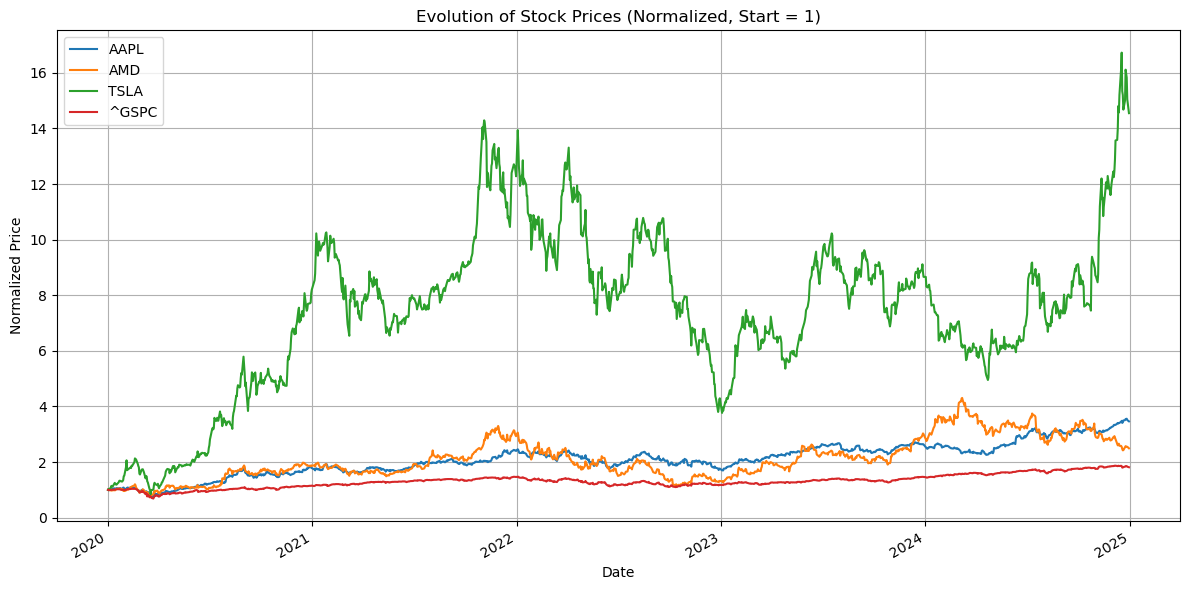

In [340]:
plt.clf()
plt.figure(figsize=(12, 6))
for stock in tickers:
    (df_prices[stock] / df_prices[stock].iloc[0]).plot(label=stock)
plt.legend()
plt.title("Evolution of Stock Prices (Normalized, Start = 1)")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()

In [341]:
#INTERPRETATION PLACEHOLDER FOR GRAPHS






## Statistics of the Strategy

Here we define the key (mostly risk-adjusted) performance measures used to evaluate the strategy.

#### **Symbol Definitions**

* $R_p$: Portfolio Return 
* $R_f$: Risk-Free Rate 
* $R_M$: Market / Benchmark Return 
* $\beta_p$: Portfolio Beta 
* $\sigma_p$: Standard Deviation of portfolio returns 
* $\sigma_d$: Standard Deviation of downside returns 
* $\sigma_{pm}$: Tracking Error, the standard deviation of the difference between portfolio and market returns, i.e., $StdDev(R_p - R_M)$.
* $\text{MaxDD}$: Maximum Drawdown 




#### **1. Core Descriptive Statistics**

These foundational metrics provide a simple yet powerful summary of the portfolio’s performance. They don’t account for risk explicitly, but form the basis of many risk-adjusted ratios.


Risk-Free Rate

The risk-free rate represents the return of an investment with zero risk of financial loss. It serves as a baseline to evaluate the performance of riskier investments, such as stocks or portfolios.

In [346]:
### Risk-free Rate

start_date_r = datetime.datetime(2020, 1, 1)
end_date_r = datetime.datetime(2024, 12, 31)

ff_data = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench', start_date_r, end_date_r)[0]
rf_daily = ff_data['RF'] / 100  #daily
rf_annual = rf_daily.mean() * 252 #yearly


print(f"Estimated Annual Risk-Free Rate: {rf_annual:.4%}")

/var/folders/1m/_4b8frh971g2zx_37b2dn9w00000gn/T/ipykernel_22412/3218344793.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors_Daily', 'famafrench', start_date_r, end_date_r)[0]


Estimated Annual Risk-Free Rate: 2.3381%


In [347]:
#INTERPRETATION PLACEHOLDER 






* **Cumulative Return:** Measures the total return of the portfolio over the entire investment period, assuming all gains are reinvested.

>$\text{Cumulative Return} = \prod_{t=1}^{T}(1 + R_t) - 1$

This metric shows how much value the portfolio has created in total. For instance, a cumulative return of 1.25 (or 125%) means the portfolio more than doubled during the backtest period.

In [349]:
#Calculate
portfolio_value  = df_position.sum(axis=1)  
returns = (portfolio_value[1:].to_numpy() / portfolio_value[:-1].to_numpy()) - 1
cumulative_returns = cumulative_return_series(returns)
cumulative_return_total = cumulative_returns[-1] - 1
print('Cumulative return: ' + str(cumulative_return_total))

Cumulative return: 4.216691708672548


In [350]:
#INTERPRETATION PLACEHOLDER 






<Figure size 640x480 with 0 Axes>

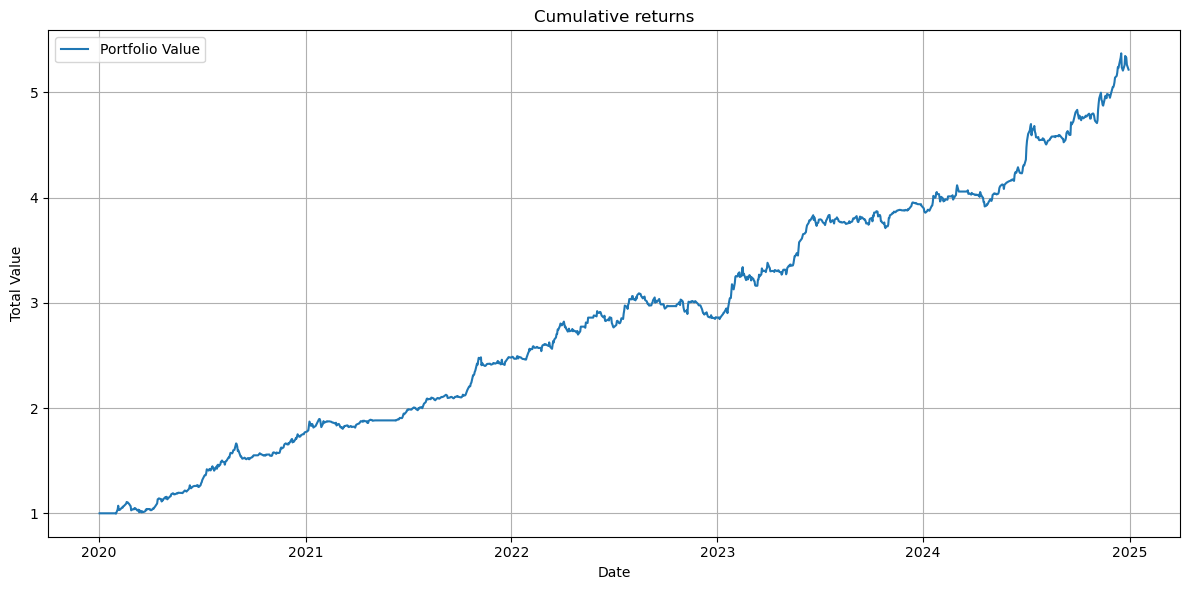

In [351]:

plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(df_position.index, df_position.sum(axis=1), label="Portfolio Value")
plt.title("Cumulative returns")
plt.xlabel("Date")
plt.ylabel("Total Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


* **Annualized Mean Return:** The average daily return of the portfolio, scaled to reflect a yearly rate. It answers the question: “How much return, on average, does this strategy produce over the course of a year?”
>$\bar{R}_p^{\text{annual}} = \bar{R}_p^{\text{daily}} \cdot 252$

In [353]:
#Calculate
mean_returns = np.sum(returns) / len(returns)
annual_mean = mean_returns*252
print('Annualized mean: ' + str(annual_mean))

Annualized mean: 0.33936914088117326


In [354]:
#INTERPRETATION PLACEHOLDER







* **Annualized Standard Deviation**: Captures the overall volatility of daily returns, scaled to a yearly level. It represents the total risk (both upside and downside) of the strategy.
>$\sigma_p^{\text{annual}} = \sigma_p^{\text{daily}} \cdot \sqrt{252}$


In [356]:
#Calculate
std_returns = np.sqrt(np.sum(np.square(returns - mean_returns)) / len(returns))
annual_std = std_returns * np.sqrt(252)
print('Annualized std:  ' + str(annual_std))

Annualized std:  0.12447140160089004


In [357]:
#INTERPRETATION PLACEHOLDER






<Figure size 640x480 with 0 Axes>

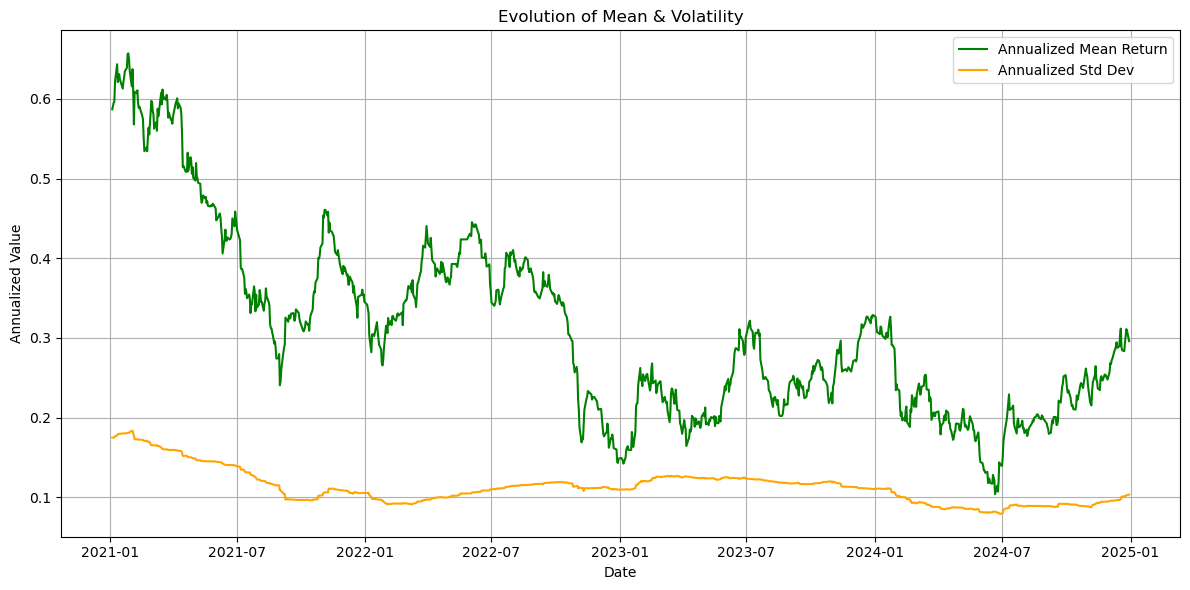

In [358]:
#Plot
returns = df_position.sum(axis=1).pct_change().dropna().to_numpy()
index = df_position.index[1:]  # skip first due to .pct_change()
window = 252

rolling_mean = []
rolling_std = []
rolling_dates = []


for i in range(window, len(returns)):
    window_returns = returns[i - window:i]
    
    mean = np.sum(window_returns) / len(window_returns)
    std = np.sqrt(np.sum((window_returns - mean) ** 2) / len(window_returns))

    rolling_mean.append(mean * 252)  # Annualized mean
    rolling_std.append(std * np.sqrt(252))  # Annualized std
    rolling_dates.append(index[i])


plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(rolling_dates, rolling_mean, label="Annualized Mean Return", color="green")
plt.plot(rolling_dates, rolling_std, label="Annualized Std Dev", color="orange")
plt.title("Evolution of Mean & Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [359]:
#INTERPRETATION PLACEHOLDER






#### **2. Core Risk-Adjusted Return Ratios**
*This group of ratios measures the return generated per unit of risk taken. It measures the "bang for your buck": for each unit of risk taken, how much return is generated?*


* **Sharpe Ratio**: Measures the excess return of an investment per unit of its total volatility (standard deviation).
Answers the question: "For every unit of total risk (both good and bad volatility) I take, how much excess return do I get back?" It is the most common measure of an investment's "bang for your buck".
 > $\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$

In [361]:
#Calculate
sharpe_ratio = (annual_mean - rf_annual) / annual_std
print('Sharpe ratio: '  + str(sharpe))

Sharpe ratio: <function sharpe at 0x167ca02c0>


In [362]:
#INTERPRETATION PLACEHOLDER






<Figure size 640x480 with 0 Axes>

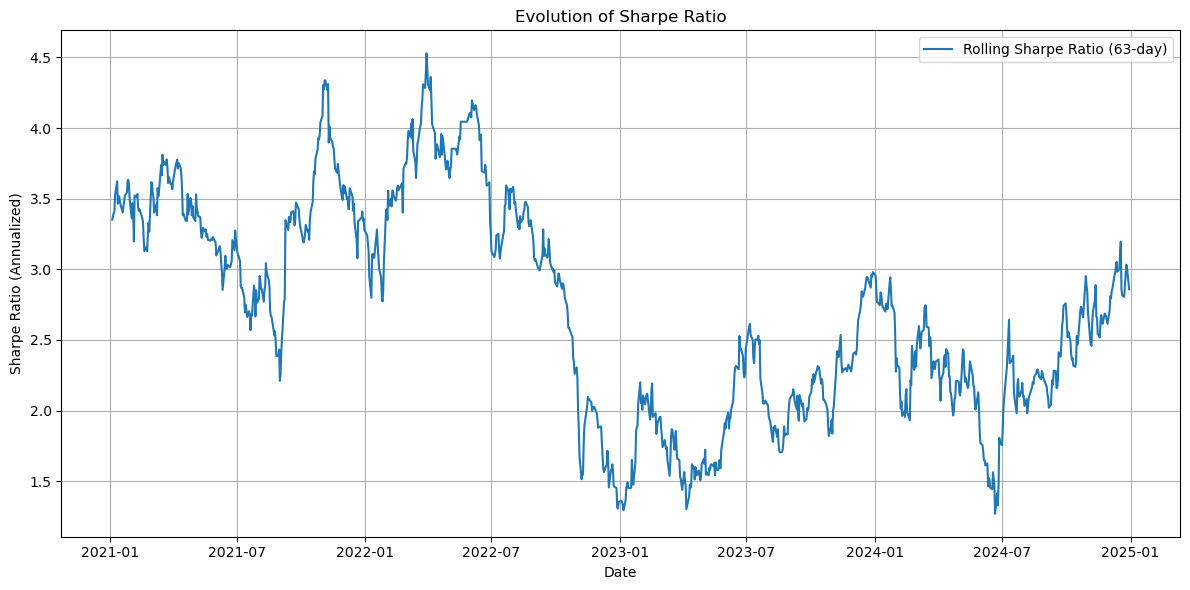

In [363]:
#Plot
window = 252  
rolling_sharpe = []

for i in range(window, len(returns)):
    window_returns = returns[i-window:i]
    mean_r = np.sum(window_returns) / len(window_returns)
    std_r = np.sqrt(np.sum((window_returns - mean_r) ** 2) / len(window_returns))
    
    if std_r != 0:
        sharpe = (mean_r / std_r) * np.sqrt(252)  # annualized
    else:
        sharpe = np.nan
    rolling_sharpe.append(sharpe)
sharpe_index = df_position.index[1:][window:]

plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(sharpe_index, rolling_sharpe, label='Rolling Sharpe Ratio (63-day)')
plt.title("Evolution of Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio (Annualized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

* **Sortino Ratio**: A "smarter" variation of the Sharpe Ratio that measures excess return per unit of downside risk (harmful volatility).
It only considers "bad" risk (when prices go down), answering: "For every unit of *losing* risk I take, how much reward am I getting?"
 > $\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}$

In [365]:
#Calculate
sortino = sortino_ratio(returns, rf_annual)
print(f"Sortino Ratio (Annualized): {sortino:.4f}")

Sortino Ratio (Annualized): 4.2528


In [366]:
#PLACEHOLDER FOR INTERPRETATION






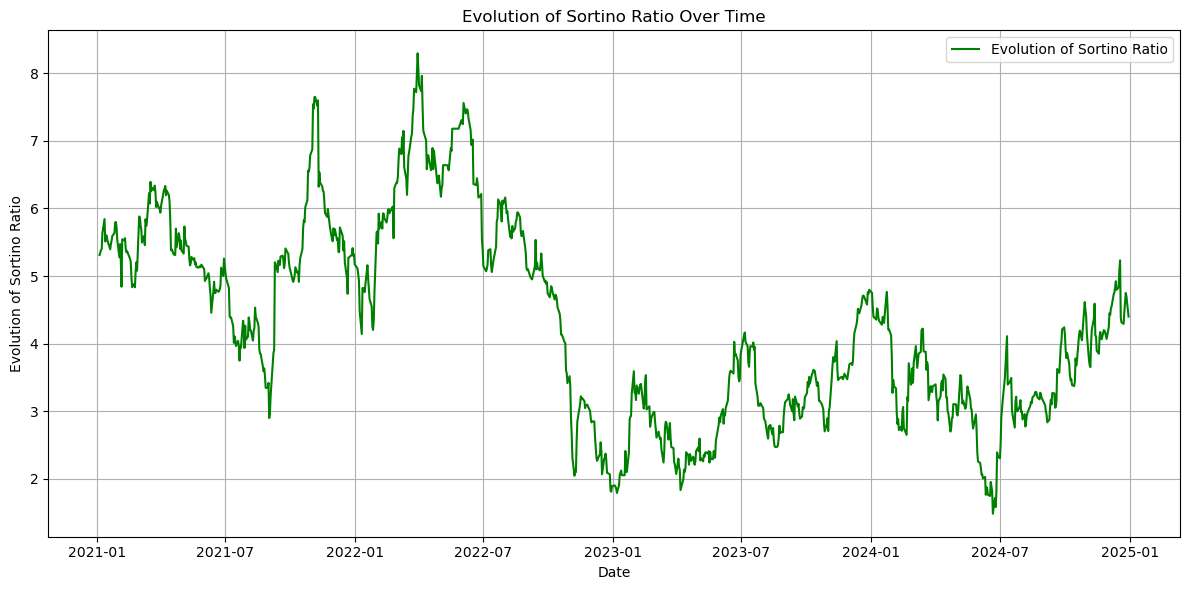

In [367]:
#Plot
rolling_metric_plot(returns, index, 252, sortino_ratio, rf_annual,
                    label_name="Evolution of Sortino Ratio", color="green")

#### **3. Performance Relative to a Benchmark**
*This group measures the strategy's ability to outperform a given market benchmark, assessing manager skill. It measures "true skill": is the strategy's success due to luck or genuine expertise?*


* **Jensen's Alpha (α)**: Measures the portfolio's abnormal return over the theoretical expected return predicted by the Capital Asset Pricing Model (CAPM). This is the measure of a manager's or strategy's "true skill". It calculates the return earned above and beyond what was expected, given the market's performance and the risk taken. A positive Alpha suggests genuine skill.

 > $\alpha_J = R_p - [R_f + \beta_p(R_M - R_f)]$

In [370]:
### Calculate Benchmark 
benchmark_prices = df_prices["^GSPC"]
benchmark_returns = (benchmark_prices[1:].to_numpy() / benchmark_prices[:-1].to_numpy()) - 1
benchmark_returns = benchmark_prices.pct_change().dropna().to_numpy()

### Calculate Jensens Alpha 
alpha, beta = compute_jensens_alpha(returns, benchmark_returns, rf_annual)
print(f"Jensen's Alpha: {alpha:.5f}")
print(f"Beta: {beta:.5f}")

Jensen's Alpha: 0.27840
Beta: 0.31609


In [371]:
#Placeholder for interpretation






<Figure size 640x480 with 0 Axes>

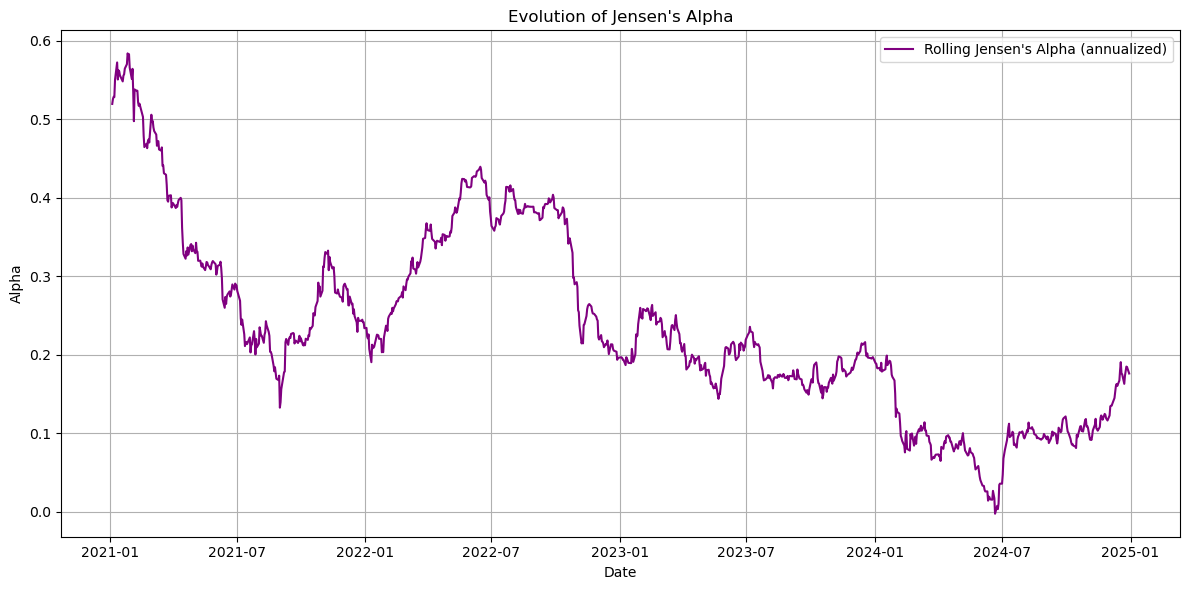

In [372]:
#Plot


window = 252  
rolling_alpha = []
rolling_beta = []
rolling_dates = []


portfolio_values = df_position.sum(axis=1)
portfolio_returns = (portfolio_values[1:].to_numpy() / portfolio_values[:-1].to_numpy()) - 1
benchmark_values = df_prices['^GSPC']
benchmark_returns = (benchmark_values[1:].to_numpy() / benchmark_values[:-1].to_numpy()) - 1


min_len = min(len(portfolio_returns), len(benchmark_returns))
portfolio_returns = portfolio_returns[:min_len]
benchmark_returns = benchmark_returns[:min_len]
dates = df_position.index[1:][:min_len]


for i in range(window, len(portfolio_returns)):
    port_window = portfolio_returns[i - window:i]
    bench_window = benchmark_returns[i - window:i]

    mean_port = np.sum(port_window) / len(port_window)
    mean_bench = np.sum(bench_window) / len(bench_window)

    var_bench = np.sum((bench_window - mean_bench) ** 2) / (len(bench_window) - 1) * 252
    cov = np.sum((port_window - mean_port) * (bench_window - mean_bench)) / (len(bench_window) - 1) * 252

    beta = cov / var_bench
    alpha = mean_port * 252 - (rf_annual + beta * (mean_bench * 252 - rf_annual))

    rolling_alpha.append(alpha)
    rolling_beta.append(beta)
    rolling_dates.append(dates[i])

# Plot
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(rolling_dates, rolling_alpha, label="Rolling Jensen's Alpha (annualized)", color='purple')
plt.title("Evolution of Jensen's Alpha")
plt.xlabel("Date")
plt.ylabel("Alpha")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

* **Treynor Ratio**: Measures the excess return earned per unit of systematic risk, as defined by beta (β).
It answers: "For every unit of market risk I took on, how much reward did I get?" This is especially useful for judging a single stock within a diversified portfolio.

 > $\text{Treynor Ratio} = \frac{R_p - R_f}{\beta_p}$

In [374]:
#Calculate
treynor = treynor_ratio(returns, beta, rf_annual)
print(f"Treynor Ratio (Annualized): {treynor:.4f}")


Treynor Ratio (Annualized): 0.6782


In [375]:
#PLACEHOLDER FOR INTERPRETATION






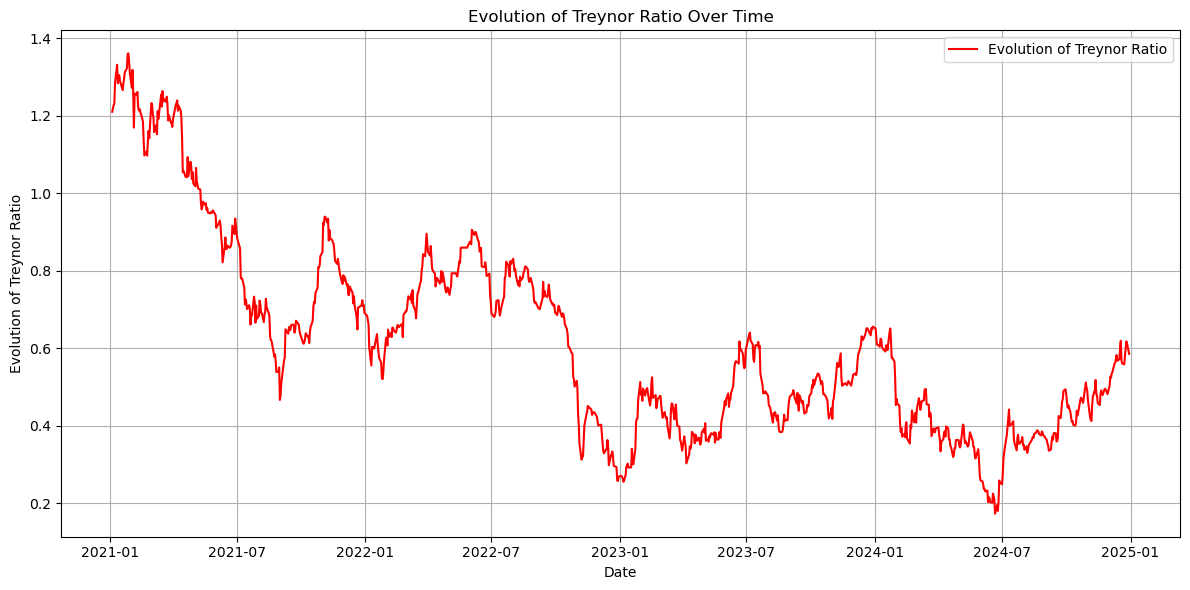

In [376]:
#Plot
rolling_metric_plot(
    returns=returns,
    index=index,
    window=252,
    metric_func=treynor_ratio,
    beta=beta,
    risk_free_rate=rf_annual,
    label_name="Evolution of Treynor Ratio",
    color="red"
)


* **Cumulative Return Comparison:**

This plot compares the total growth of the portfolio against a benchmark (e.g., the S&P 500) over the entire backtest period. It shows how each euro (or dollar) invested would have evolved over time, assuming continuous reinvestment of profits.

$\text{Cumulative Return}_t = \prod{i=1}^t (1 + R_i)$

By plotting both curves side-by-side and normalizing them to 1.0 at the start, we can easily assess:
	<Relative performance over time
	<Timing of gains and drawdowns
	<Whether the portfolio outperformed or underperformed the benchmark overall



<Figure size 640x480 with 0 Axes>

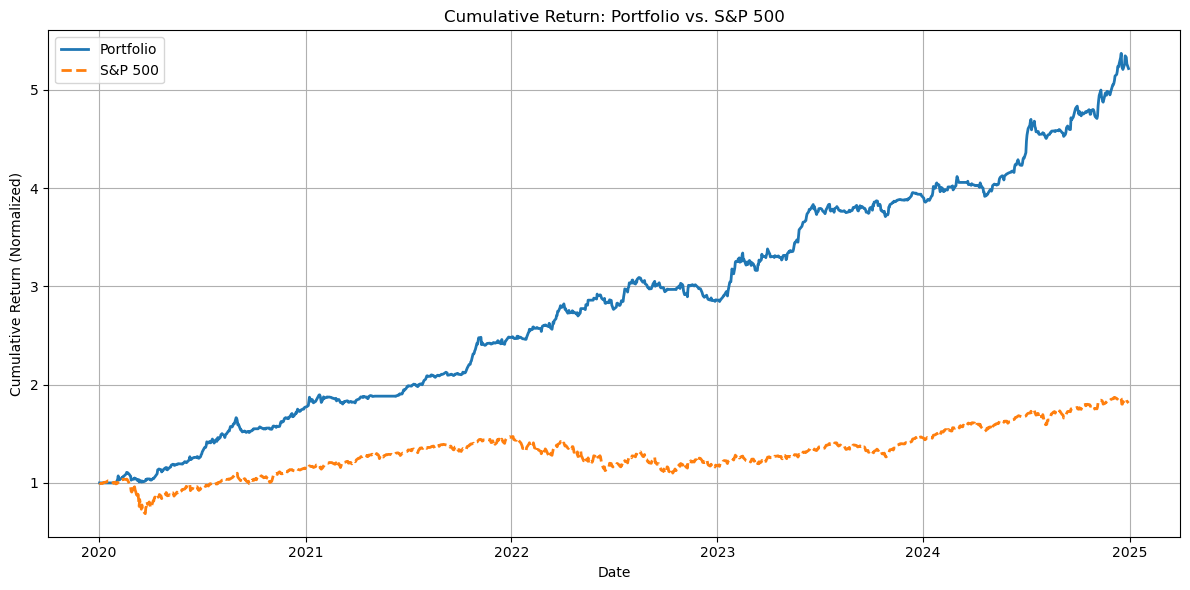

In [378]:
#Calculate
normalized_portfolio = portfolio_value / portfolio_value.iloc[0]
normalized_benchmark = df_prices['^GSPC'] / df_prices['^GSPC'].iloc[0]

# Plot
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(normalized_portfolio, label='Portfolio', linewidth=2)
plt.plot(normalized_benchmark, label='S&P 500', linewidth=2, linestyle='--')

plt.title("Cumulative Return: Portfolio vs. S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* **Information Ratio (IR)**: Measures the *consistency* of a portfolio's excess returns over a benchmark relative to the volatility of those returns (tracking error). It asks: "How consistently does my strategy beat the benchmark, and is that outperformance smooth or erratic?" A high IR indicates that the ability to outperform is reliable.

 > $\text{Information Ratio} = \frac{R_p - R_M}{\sigma_{pm}}$




In [380]:
#Calculate
info_ratio = information_ratio(returns, benchmark_returns)
print(f"Information Ratio (Annualized): {info_ratio:.4f}")

Information Ratio (Annualized): 1.0970


In [381]:
#PLACEHOLDER FOR INTERPRETATION








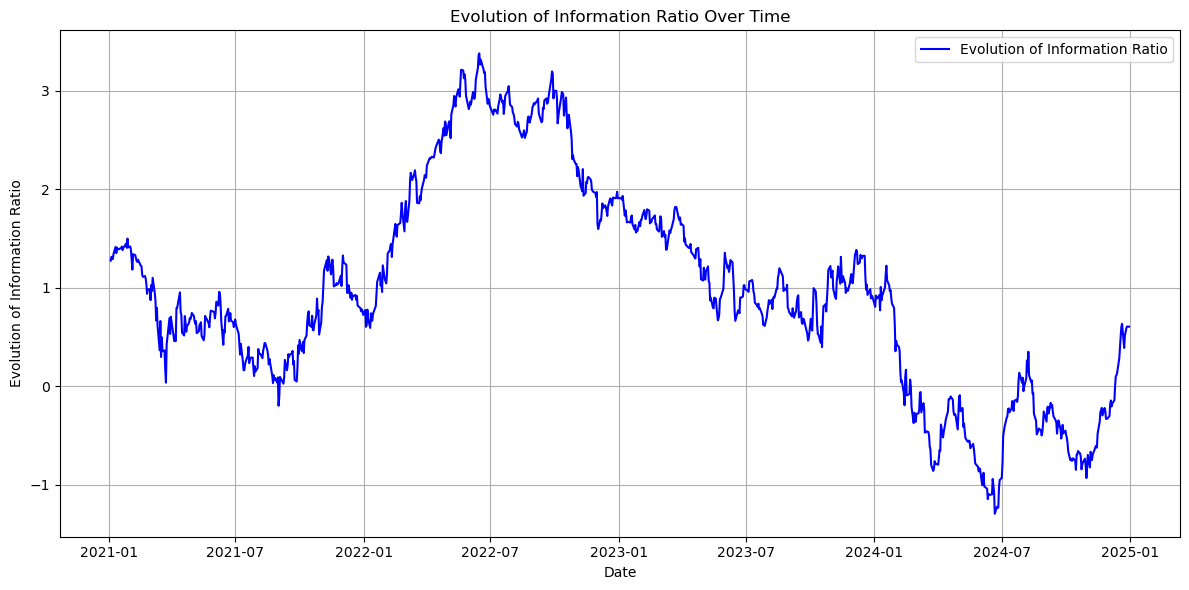

In [382]:
#Plot
min_len = min(len(returns), len(benchmark_returns))
combined_returns = np.column_stack((returns[:min_len], benchmark_returns[:min_len]))
aligned_index = index[:min_len]

rolling_metric_plot(
    returns=combined_returns,                 
    index=aligned_index,
    window=252,
    metric_func=lambda x: information_ratio(x[:, 0], x[:, 1]),  
    label_name="Evolution of Information Ratio",
    color="blue"
)

#### **4. Risk & Drawdown-Based Measures**
*This group focuses on performance during adverse periods and quantifies potential losses. It focuses on "resilience": how does the strategy perform under stress and during its worst periods?*
*


* **Value-at-Risk (VaR)**: A statistical measure that estimates the maximum potential loss over a specific time frame for a given confidence level. It's the "sleep-at-night" number. It answers a simple question: "What is the most I can expect to lose over a given period (e.g., one day) with 95% confidence?" It is a key metric for risk management.


* **Value-at-Risk (VaR)**: A statistical measure that estimates the maximum potential loss over a specific time frame for a given confidence level. It's the "sleep-at-night" number. It answers a simple question: "What is the most I can expect to lose over a given period (e.g., one day) with 95% confidence?" It is a key metric for risk management.


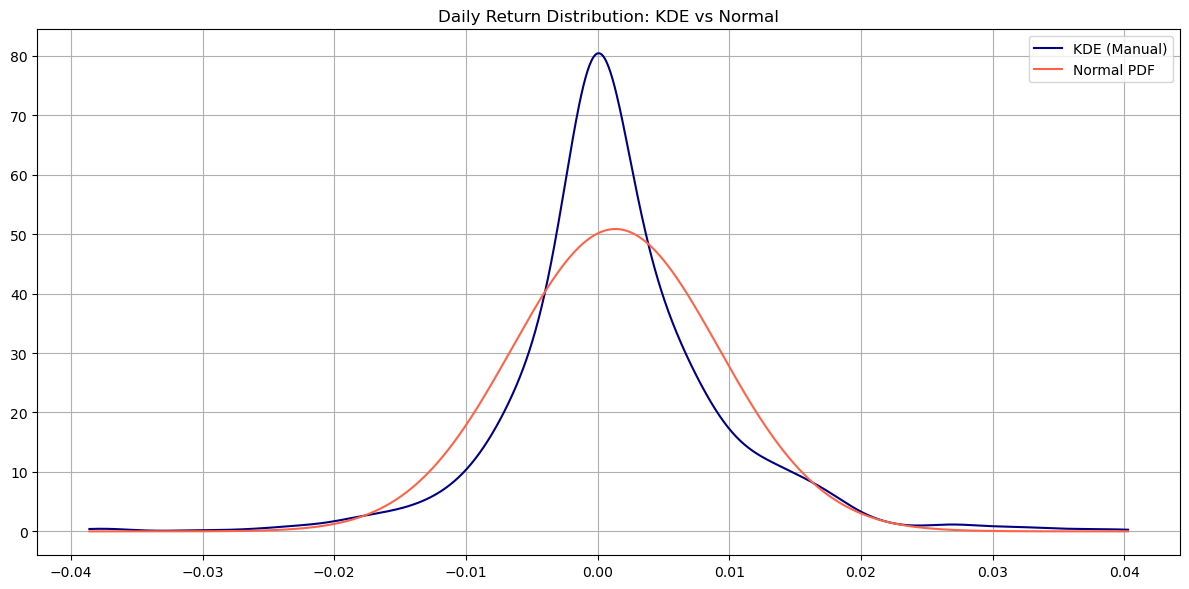

90% VaR — Historical: -0.6493%, Gaussian: -0.8706%
95% VaR — Historical: -1.0256%, Gaussian: -1.1556%
99% VaR — Historical: -1.9213%, Gaussian: -1.6901%


In [388]:
# VaR
# Value at Risk (Historical vs. Normal) with Manual KDE 

# Step 1: Compute mean and std of returns
mean_daily_return = np.sum(returns) / len(returns)
std_daily_return = np.sqrt(np.sum((returns - mean_daily_return) ** 2) / (len(returns) - 1))

# Define Kernel Density function
def manual_kde(data, grid, bw):
    estimate = np.zeros_like(grid)
    for val in data:
        estimate += np.exp(-0.5 * ((grid - val) / bw) ** 2)
    estimate /= (len(data) * bw * np.sqrt(2 * np.pi))
    return estimate


bw = 1.06 * std_daily_return * len(returns) ** (-1 / 5)
grid = np.linspace(min(returns), max(returns), 1000)
kde_curve = manual_kde(returns, grid, bw)

#Plot KDE and Normal PDF
def normal_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

plt.figure(figsize=(12, 6))
plt.plot(grid, kde_curve, label='KDE (Manual)', color='navy')
plt.plot(grid, normal_pdf(grid, mean_daily_return, std_daily_return), label='Normal PDF', color='tomato')
plt.title("Daily Return Distribution: KDE vs Normal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Historical VaR 
def historical_var(data, level):
    sorted_returns = np.sort(data)
    index = int((1 - level) * len(sorted_returns))
    return sorted_returns[index]

# Gaussian VaR 
def gaussian_var(mean, std, level):
    z = {0.90: 1.2816, 0.95: 1.6449, 0.99: 2.3263}[level]
    return mean - z * std

for conf in [0.90, 0.95, 0.99]:
    var_hist = historical_var(returns, conf)
    var_norm = gaussian_var(mean_daily_return, std_daily_return, conf)
    print(f"{int(conf*100)}% VaR — Historical: {var_hist:.4%}, Gaussian: {var_norm:.4%}")

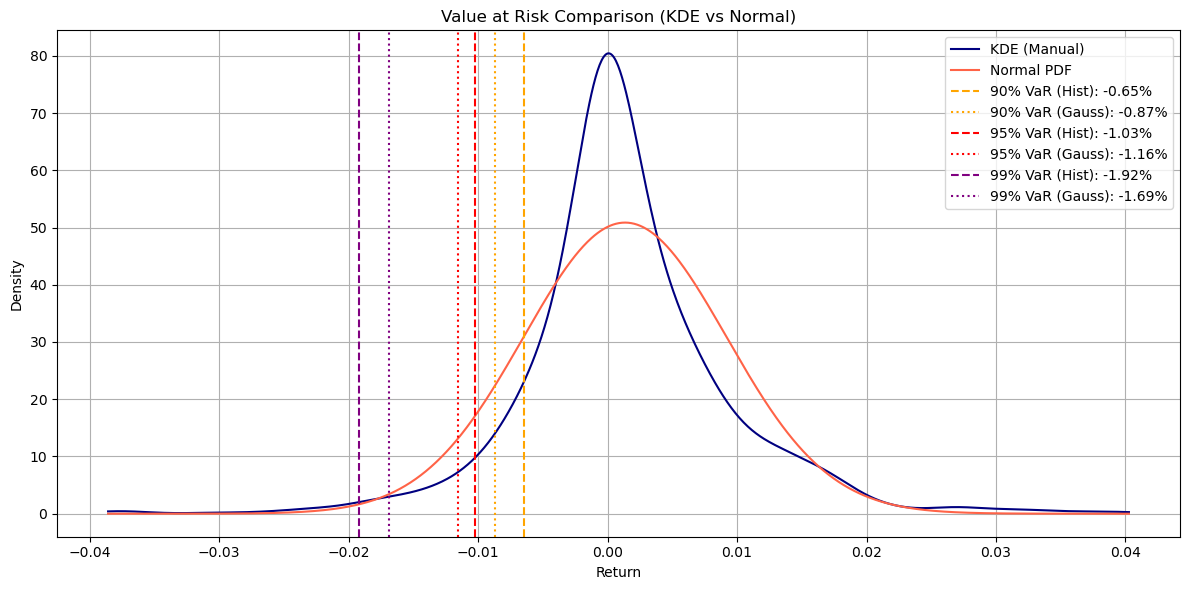

In [390]:
# Define confidence levels
conf_levels = [0.90, 0.95, 0.99]
colors = ['orange', 'red', 'purple']

plt.figure(figsize=(12, 6))

# Plot KDE and normal PDF
plt.plot(grid, kde_curve, label='KDE (Manual)', color='navy')
plt.plot(grid, normal_pdf(grid, mean_daily_return, std_daily_return), label='Normal PDF', color='tomato')

# Plot VaRs
for i, conf in enumerate(conf_levels):
    var_hist = historical_var(returns, conf)
    var_norm = gaussian_var(mean_daily_return, std_daily_return, conf)

    plt.axvline(var_hist, linestyle='--', color=colors[i], label=f'{int(conf*100)}% VaR (Hist): {var_hist:.2%}')
    plt.axvline(var_norm, linestyle=':', color=colors[i], label=f'{int(conf*100)}% VaR (Gauss): {var_norm:.2%}')

plt.title("Value at Risk Comparison (KDE vs Normal)")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [392]:
# Skewness
m2 = np.mean((returns - mean_daily_return)**2)
m3 = np.mean((returns - mean_daily_return)**3)
skewness = m3 / (m2 ** 1.5)

# Kurtosis
m4 = np.mean((returns - mean_daily_return)**4)
kurtosis = m4 / (m2 ** 2)

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

Skewness: 0.2823
Kurtosis: 6.9538


The return distribution exhibits a mild positive skew (0.28), suggesting a slight tendency for extreme positive returns. More critically, the kurtosis is substantially higher than that of a normal distribution (6.95 vs. 3), confirming the presence of fat tails. This aligns with our observation that the historical VaR exceeds the Gaussian VaR at the 99% level, illustrating that the normal distribution underestimates extreme downside risk.

To assess the downside risk of our strategy, we compared historical and parametric (Gaussian) Value at Risk (VaR) at various confidence levels. The 90% and 95% VaRs derived from the historical distribution were less negative than those from the fitted normal distribution, while the 99% historical VaR was more negative than its Gaussian counterpart. This pattern points toward the presence of fat tails in the distribution of returns.

To confirm this, we computed the skewness and kurtosis of the daily return distribution. The positive skewness of 0.2823 indicates a slight tendency toward extreme positive returns, while the excess kurtosis of 6.95 clearly confirms heavy tails. This means that extreme returns, especially losses, are more frequent than a normal distribution would suggest.

Taken together, these findings highlight the limitations of assuming normality in risk estimation. In particular, the Gaussian VaR underestimates the true risk in the tails, which underscores the importance of using non-parametric methods (such as historical VaR or kernel density estimation) for accurate risk assessment in fat-tailed return distributions.

* **Calmar Ratio**: Measures risk-adjusted return by dividing the annualized rate of return by the absolute value of the portfolio's maximum drawdown. It's a "pain vs. gain" ratio popular with professional traders. It compares the annual return to the worst loss (maximum drawdown) the strategy ever experienced. A high Calmar ratio means the strategy recovers well from its worst periods.

 > $\text{Calmar Ratio} = \frac{R_p}{\vert\text{MaxDD}\vert}$


In [396]:
#Calculate
calmar = calmar_ratio_from_window(returns)  # daily returns
print(f"Calmar Ratio (Annualized): {calmar:.4f}")

Calmar Ratio (Annualized): 3.7373


In [398]:
#PLACEHOLDER FOR INTERPRETATION






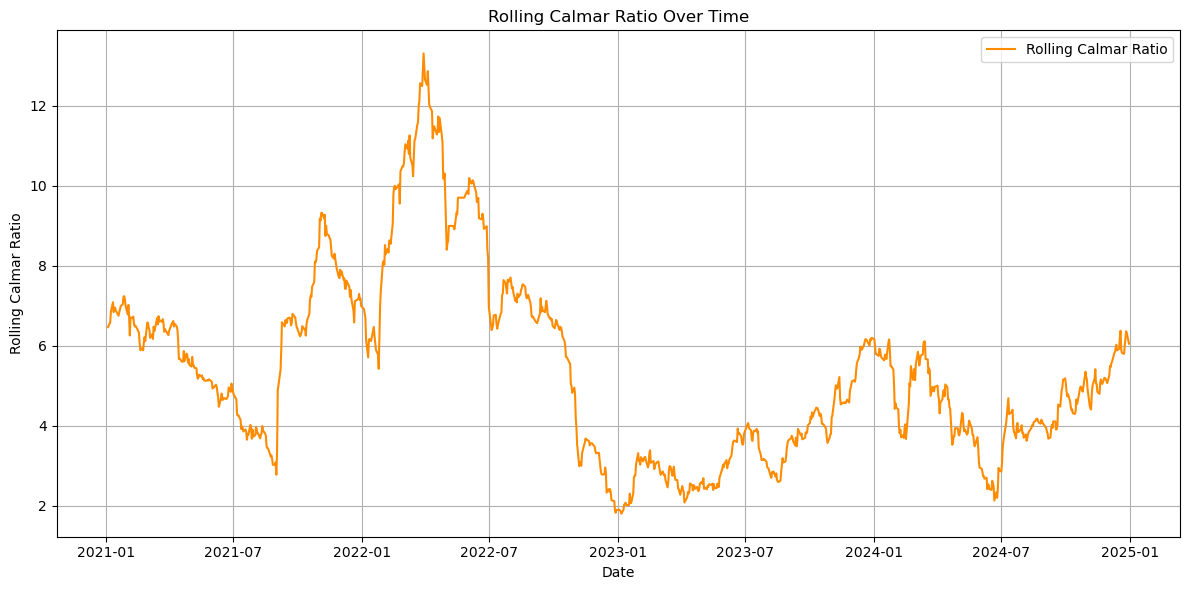

In [400]:
#Plot
rolling_metric_plot(
    returns=returns,
    index=index,
    window=252,
    metric_func=calmar_ratio_from_window,
    label_name="Rolling Calmar Ratio",
    color="darkorange"
)

#### **5. Ratios for Easier Interpretation**
*This metric adjusts performance to make it more directly comparable with a benchmark.*

* **Modigliani Ratio (M² Ratio)**: An "apples-to-apples" comparison tool. It adjusts the portfolio's risk to be exactly the same as a benchmark's, then shows what the portfolio's return *would have been*. This makes it incredibly easy to see if we truly beat the market on a risk-adjusted basis.

 > $M^2 = (\frac{R_p - R_f}{\sigma_p}) \cdot \sigma_M + R_f$

In [403]:
#Calculate 
benchmark_std_annual = np.std(benchmark_returns, ddof=1) * np.sqrt(252)

m2 = modigliani_ratio(sharpe, benchmark_std_annual, rf_annual)
print(f"Modigliani Ratio (M²): {m2:.4%}")

Modigliani Ratio (M²): 63.3631%


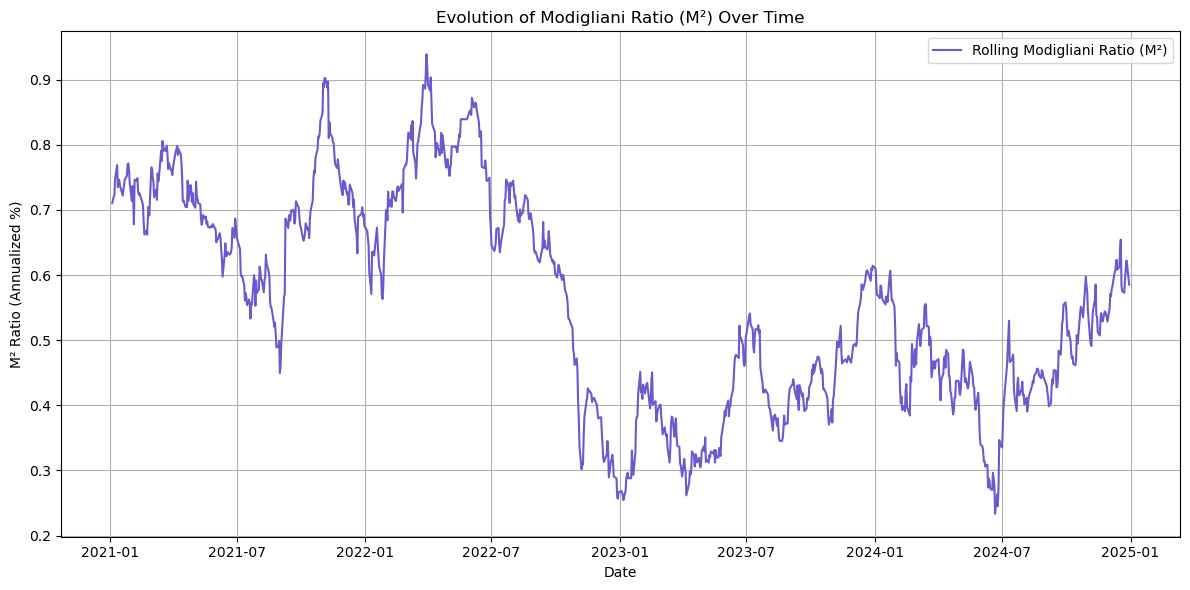

In [405]:
#Plot
window = 252  
benchmark_std_annual = np.std(benchmark_returns, ddof=1) * np.sqrt(252)

rolling_m2 = []
rolling_dates = []

for i in range(window, len(returns)):
    window_returns = returns[i - window:i]
    daily_rf = rf_annual / 252

    excess_returns = window_returns - daily_rf
    mean_excess = np.sum(excess_returns) / len(excess_returns)
    std = np.sqrt(np.sum((window_returns - np.mean(window_returns)) ** 2) / len(window_returns))

    if std == 0:
        m2 = np.nan
    else:
        sharpe = (mean_excess / std) * np.sqrt(252)
        m2 = rf_annual + sharpe * benchmark_std_annual

    rolling_m2.append(m2)
    rolling_dates.append(index[i])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rolling_dates, rolling_m2, color='slateblue', label='Rolling Modigliani Ratio (M²)')
plt.title("Evolution of Modigliani Ratio (M²) Over Time")
plt.xlabel("Date")
plt.ylabel("M² Ratio (Annualized %)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()